In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [6]:
df=pd.read_excel(r"C:\Users\233692\Downloads\Online Retail.xlsx")

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [10]:
df.isnull().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [11]:
# removing null value of cutomer from the data set
df = df[pd.notnull(df['CustomerID'])]

In [12]:
# excluding negative value from quantity and unit price
df = df[(df.Quantity>0)&(df.UnitPrice>0)]

In [13]:
df = df[~df['StockCode'].str.contains("C", na=False)]

In [14]:
# droping duplicate values
df = df.drop_duplicates()

<AxesSubplot:>

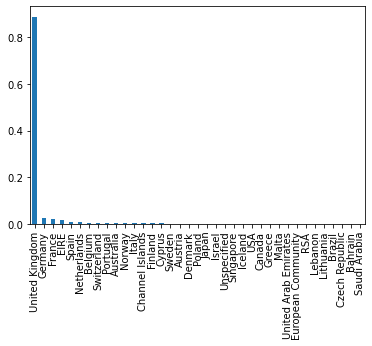

In [15]:
df.Country.value_counts(normalize=True).plot(kind='bar')

In [16]:
df = df[df.Country == 'United Kingdom']

In [17]:
print('Orders from {} to {}'.format(df['InvoiceDate'].min(),
                                    df['InvoiceDate'].max()))

Orders from 2010-12-01 08:26:00 to 2011-12-09 12:49:00


In [18]:
df_recency = df.groupby(by='CustomerID',
                        as_index=False)['InvoiceDate'].max()
df_recency.columns = ['CustomerID', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency.head()

,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18 10:01:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2


In [19]:
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:49:00')

In [20]:
today_date = dt.datetime(2011, 12, 11)

In [21]:
frequency_df = df.groupby(
    by=['CustomerID'], as_index=False)['InvoiceDate'].count()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,100
2,12748.0,4345
3,12749.0,196
4,12820.0,59


In [22]:
df["Monetary"] = df['Quantity']*df['UnitPrice']     # creating monetary as a new column
Monetary = df.groupby('CustomerID')['Monetary'].sum()
Monetary = Monetary.reset_index()
Monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,4128.71
2,12748.0,32509.54
3,12749.0,4014.18
4,12820.0,942.34


In [23]:
rf_df = df_recency.merge(frequency_df, on='CustomerID')
rfm_df = rf_df.merge(Monetary, on='CustomerID').drop(
    columns='LastPurchaseDate')
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,1,100,4128.71
2,12748.0,0,4345,32509.54
3,12749.0,3,196,4014.18
4,12820.0,2,59,942.34


In [24]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['M_rank']/rfm_df['M_rank'].max())*100
 
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,12346.0,325,1,77183.60,3.615702,0.881226,99.872286
1,12747.0,1,100,4128.71,97.920971,75.759898,92.745849
2,12748.0,0,4345,32509.54,100.000000,99.948914,99.386973
3,12749.0,3,196,4014.18,93.530475,89.719029,92.337165
4,12820.0,2,59,942.34,95.893595,61.328225,61.966794


In [25]:
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * \
    rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['CustomerID', 'RFM_Score']].head(7)

,CustomerID,RFM_Score
0,12346.0,2.89
1,12747.0,4.44
2,12748.0,4.98
3,12749.0,4.59
4,12820.0,3.34
5,12821.0,0.32
6,12822.0,2.83


In [26]:
rfm_df['RFM_Score'].describe()

count    3915.000000
mean        2.504708
std         1.291428
min         0.030000
25%         1.420000
50%         2.470000
75%         3.580000
max         4.990000
Name: RFM_Score, dtype: float64

Rating Customer based upon the RFM score
* rfm score >4.5 : Top Customer
* 4.5 > rfm score > 4 : High Value Customer
* 4>rfm score >3 : Medium value customer
* 3>rfm score>1.6 : Low-value customer
* rfm score<1.6 :Lost Customer

In [27]:
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] > 4.5,
                                      "Top Customers",
                                      (np.where(
                                        rfm_df['RFM_Score'] > 4,
                                        "High value Customer",
                                        (np.where(
                                rfm_df['RFM_Score'] > 3,
                             "Medium Value Customer",
                             np.where(rfm_df['RFM_Score'] > 1.6,
                            'Low Value Customers', 'Lost Customers'))))))
rfm_df[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20)

,CustomerID,RFM_Score,Customer_segment
0,12346.0,2.89,Low Value Customers
1,12747.0,4.44,High value Customer
2,12748.0,4.98,Top Customers
3,12749.0,4.59,Top Customers
4,12820.0,3.34,Medium Value Customer
5,12821.0,0.32,Lost Customers
6,12822.0,2.83,Low Value Customers
7,12823.0,2.59,Low Value Customers
8,12824.0,1.87,Low Value Customers
9,12826.0,3.84,Medium Value Customer


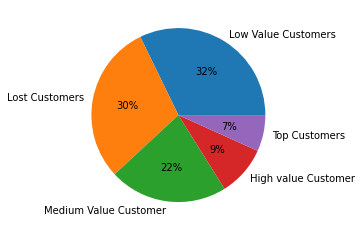

In [28]:
import matplotlib.pyplot as plt
plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

In [29]:
rfm_df['Avg_Order_Value'] = rfm_df['Monetary'] / rfm_df['Frequency']

In [30]:
rfm_df['Avg_Order_Value']

0       77183.600000
1          41.287100
2           7.482058
3          20.480510
4          15.971864
            ...     
3910       18.060000
3911       11.545714
3912       14.837500
3913        2.835806
3914       26.405507
Name: Avg_Order_Value, Length: 3915, dtype: float64

In [31]:
rfm_df["Purchase_Frequency"] = rfm_df['Frequency'] / rfm_df.shape[0]

In [32]:
rfm_df["Purchase_Frequency"]

0       0.000255
1       0.025543
2       1.109834
3       0.050064
4       0.015070
          ...   
3910    0.002554
3911    0.001788
3912    0.003065
3913    0.183908
3914    0.017625
Name: Purchase_Frequency, Length: 3915, dtype: float64

In [33]:
rfm_df['Profit_Margin'] = rfm_df['Monetary'] * 0.05

In [34]:
rfm_df['Profit_Margin']

0       3859.1800
1        206.4355
2       1625.4770
3        200.7090
4         47.1170
          ...    
3910       9.0300
3911       4.0410
3912       8.9025
3913     102.0890
3914      91.0990
Name: Profit_Margin, Length: 3915, dtype: float64

In [35]:
repeat_rate = rfm_df[rfm_df.Frequency > 1].shape[0] / rfm_df.shape[0]
churn_rate = 1 - repeat_rate

In [36]:
rfm_df['cv'] = (rfm_df['Avg_Order_Value'] * rfm_df["Purchase_Frequency"])

In [37]:
rfm_df['cv'] 

0       19.714840
1        1.054587
2        8.303842
3        1.025333
4        0.240700
          ...    
3910     0.046130
3911     0.020644
3912     0.045479
3913     0.521527
3914     0.465384
Name: cv, Length: 3915, dtype: float64

In [38]:
rfm_df['cltv'] = (rfm_df['cv'] / churn_rate) * rfm_df['Profit_Margin']

In [39]:
rfm_df['cltv']

0       4.380374e+06
1       1.253400e+04
2       7.771104e+05
3       1.184827e+04
4       6.529446e+02
            ...     
3910    2.398262e+01
3911    4.802847e+00
3912    2.331015e+01
3913    3.065342e+03
3914    2.440891e+03
Name: cltv, Length: 3915, dtype: float64

In [40]:
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment,Avg_Order_Value,Purchase_Frequency,Profit_Margin,cv,cltv
0,12346.0,325,1,77183.60,3.62,0.88,99.87,2.89,Low Value Customers,77183.600000,0.000255,3859.1800,19.714840,4.380374e+06
1,12747.0,1,100,4128.71,97.92,75.76,92.75,4.44,High value Customer,41.287100,0.025543,206.4355,1.054587,1.253400e+04
2,12748.0,0,4345,32509.54,100.00,99.95,99.39,4.98,Top Customers,7.482058,1.109834,1625.4770,8.303842,7.771104e+05
3,12749.0,3,196,4014.18,93.53,89.72,92.34,4.59,Top Customers,20.480510,0.050064,200.7090,1.025333,1.184827e+04
4,12820.0,2,59,942.34,95.89,61.33,61.97,3.34,Medium Value Customer,15.971864,0.015070,47.1170,0.240700,6.529446e+02


In [41]:
rfm_df['cltv'] = rfm_df['cltv'].round(2)

In [42]:
rfm_df

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment,Avg_Order_Value,Purchase_Frequency,Profit_Margin,cv,cltv
0,12346.0,325,1,77183.60,3.62,0.88,99.87,2.89,Low Value Customers,77183.600000,0.000255,3859.1800,19.714840,4380373.61
1,12747.0,1,100,4128.71,97.92,75.76,92.75,4.44,High value Customer,41.287100,0.025543,206.4355,1.054587,12534.00
2,12748.0,0,4345,32509.54,100.00,99.95,99.39,4.98,Top Customers,7.482058,1.109834,1625.4770,8.303842,777110.43
3,12749.0,3,196,4014.18,93.53,89.72,92.34,4.59,Top Customers,20.480510,0.050064,200.7090,1.025333,11848.27
4,12820.0,2,59,942.34,95.89,61.33,61.97,3.34,Medium Value Customer,15.971864,0.015070,47.1170,0.240700,652.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3910,18280.0,277,10,180.60,7.89,15.13,13.92,0.67,Lost Customers,18.060000,0.002554,9.0300,0.046130,23.98
3911,18281.0,180,7,80.82,19.95,9.91,2.61,0.36,Lost Customers,11.545714,0.001788,4.0410,0.020644,4.80
3912,18282.0,7,12,178.05,88.38,18.34,13.51,1.30,Lost Customers,14.837500,0.003065,8.9025,0.045479,23.31
3913,18283.0,3,720,2041.78,93.53,99.31,81.23,4.41,High value Customer,2.835806,0.183908,102.0890,0.521527,3065.34


In [70]:
df=df['InvoiceDate'].strftime("%d-%m-%Y")

KeyError: 'InvoiceDate'

In [60]:
df

,datetime,date,time
0,2010-12-01 08:26:00,2010-12-01,08:26:00
1,2010-12-02 08:26:00,2010-12-02,08:26:00
2,2010-12-03 08:26:00,2010-12-03,08:26:00
3,2010-12-04 08:26:00,2010-12-04,08:26:00
4,2010-12-05 08:26:00,2010-12-05,08:26:00
5,2010-12-06 08:26:00,2010-12-06,08:26:00
6,2010-12-07 08:26:00,2010-12-07,08:26:00
7,2010-12-08 08:26:00,2010-12-08,08:26:00
8,2010-12-09 08:26:00,2010-12-09,08:26:00
9,2010-12-10 08:26:00,2010-12-10,08:26:00
